<a href="https://colab.research.google.com/github/lukewys/midi-ddsp/blob/main/colab/MIDI_DDSP_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIDI-DDSP Demo
Here is the demo where you can automatically synthesize MIDI with the proposed model and then edit the note expression controls of each note. This can be seen as a prototype of our system where users can interact with the model and create the desired music audio together.

[MIDI-DDSP ICLR paper]()

[Audio Examples]()

<img src="https://midi-ddsp.github.io/pics/midi-ddsp-diagram-hori.png" alt="MIDI-DDSP" width="700">

### Instructions for running:

* Make sure to use a GPU runtime, click:  __Runtime >> Change Runtime Type >> GPU__
* Press ▶️ on the left of each of the cells
* View the code: Double-click any of the cells
* Hide the code: Double click the right side of the cell


In [ ]:
#@title #Install Dependencies, Import Code and Setup Models

#@markdown Run this cell to install dependencies, import codes, 
#@markdown setup utility functions and load MIDI-DDSP model weights.
#@markdown Running this cell could take a while.

!pip install -q ddsp pretty_midi librosa pandas music21

!pip install -q git+https://github.com/lukewys/qgrid.git

!gdown -q --id 1HbS2fQItqIeeTqalVd65qvw8PeuvYSYz
!unzip -q midi_ddsp_model_weights_urmp_9_10.zip
!git clone -q https://github.com/magenta/midi-ddsp.git
!wget -q https://keymusician01.s3.amazonaws.com/FluidR3_GM.zip
!unzip -q FluidR3_GM.zip

# Ignore a bunch of deprecation warnings
import sys
sys.path.append('./midi-ddsp')
import warnings
warnings.filterwarnings("ignore")

import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import pandas as pd
import qgrid
import music21
from IPython.display import Javascript
import IPython.display as ipd
from google.colab import output
output.enable_custom_widget_manager()

from utils.training_utils import set_seed, get_hp
from hparams_synthesis_generator import hparams as hp
from midi_ddsp.get_model import get_model, get_fake_data
import train_expression_generator
from midi_ddsp.expression_generator import ExpressionGenerator
from utils.audio_io import save_wav
from utils.midi_synthesis_utils import synthesize_mono_midi, synthesize_bach
from synthesize_midi import synthesize_midi
from utils.inference_utils import conditioning_df_to_audio, get_process_group
from data_handling.instrument_name_utils import INST_NAME_TO_ID_DICT, INST_NAME_LIST

set_seed(1234)
sample_rate = 16000

synthesis_generator_path = r'./midi_ddsp_model_weights_urmp_9_10/synthesis_generator/50000'
hp_dict = get_hp(os.path.join(os.path.dirname(synthesis_generator_path), 'train.log'))
for k, v in hp_dict.items():
    setattr(hp, k, v)

synthesis_generator = get_model(hp)
synthesis_generator._build(get_fake_data(hp))
synthesis_generator.load_weights(synthesis_generator_path)

n_out=6
expression_generator_path = r'./midi_ddsp_model_weights_urmp_9_10/expression_generator/5000'
expression_generator = ExpressionGenerator(n_out=n_out, nhid=128)
fake_data = train_expression_generator.get_fake_data(n_out)
expression_generator(fake_data['cond'], out=fake_data['target'], training=True)
expression_generator.load_weights(expression_generator_path)

print('Done!')

def plot_spec(wav, sr, title='', play=True, vmin=-8, vmax=1, save_path=None):
    D = np.log(np.abs(librosa.stft(wav, n_fft=512 + 256)))
    librosa.display.specshow(D, sr=sr, vmin=vmin, vmax=vmax, cmap='magma')
    plt.title(title)
    wav = np.clip(wav, -1, 1)
    if play:
        ipd.display(ipd.Audio(wav, rate=sr))
    if save_path:
        plt.savefig(save_path)
        plt.close()

CODE_EXPRESSION_KEY_TO_PAPER_NAME_DICT = {
    'amplitude_mean':'volume',
    'amplitude_std':'vol_fluc',
    'amplitudes_max_pos':'vol_peak_pos',
    'vibrato_extend':'vibrato',
    'brightness':'brightness',
    'attack_level':'attack',
    'pitch':'pitch',
    'note_length':'note_length',
    'onset':'onset',
    'offset':'offset',
}

PAPER_NAME_TO_CODE_EXPRESSION_DICT = {v:k for k,v in CODE_EXPRESSION_KEY_TO_PAPER_NAME_DICT.items()}

EDIT_DF_NAME_ORDER = ['volume', 'vol_fluc', 'vol_peak_pos', 'vibrato', 'brightness', 'attack', 'pitch', 'note_length']

COND_DF_NAME_ORDER = ['amplitude_mean', 'amplitude_std', 'vibrato_extend', 'brightness', 'attack_level', 'amplitudes_max_pos', 'pitch', 'onset', 'offset', 'note_length']

def conditioning_df_to_edit_df(conditioning_df):
  edit_df = conditioning_df.copy()
  edit_df = edit_df.rename(columns=CODE_EXPRESSION_KEY_TO_PAPER_NAME_DICT)
  return edit_df[EDIT_DF_NAME_ORDER]

def edit_df_to_conditioning_df(edit_df):
  conditioning_df = edit_df.copy()
  note_length = conditioning_df['note_length'].values
  offset = np.cumsum(note_length)
  onset = np.concatenate([[0],offset[:-1]])
  conditioning_df['onset']=onset
  conditioning_df['offset']=offset
  conditioning_df = conditioning_df.rename(columns=PAPER_NAME_TO_CODE_EXPRESSION_DICT)
  return conditioning_df[COND_DF_NAME_ORDER]

GAIN_ADJUST_DB_DICT = {    
    'string_set': {    
        'Soprano': 2,
        'Alto': 2,
        'Tenor': -1,
        'Bass': -1,
    },
    'woodwind_set': {    
        'Soprano': 1.5,
        'Alto': 1.2,
        'Tenor': 0,
        'Bass': 1.8,
    },
    'brasswind_set': {    
        'Soprano': 2,
        'Alto': 2,
        'Tenor': 5.6,
        'Bass': 2.9,
    },

}

from google.colab import files
def upload_midi():
  midi_files = files.upload()
  fnames = list(midi_files.keys())
  return fnames

     |████████████████████████████████| 197 kB 5.3 MB/s 
     |████████████████████████████████| 5.6 MB 35.0 MB/s 
     |████████████████████████████████| 4.1 MB 37.1 MB/s 
     |████████████████████████████████| 1.1 MB 33.2 MB/s 
     |████████████████████████████████| 3.6 MB 35.9 MB/s 
     |████████████████████████████████| 87 kB 6.4 MB/s 
     |████████████████████████████████| 1.1 MB 44.3 MB/s 
     |████████████████████████████████| 64 kB 2.9 MB/s 
     |████████████████████████████████| 210 kB 43.9 MB/s 
     |████████████████████████████████| 374 kB 35.0 MB/s 
     |████████████████████████████████| 20.2 MB 1.4 MB/s 
     |████████████████████████████████| 51 kB 7.1 MB/s 
     |████████████████████████████████| 208 kB 48.1 MB/s 
Done!


## Monophonic MIDI Synthesis

Generating: 100%|██████████| 4712/4712 [01:43<00:00, 45.71it/s]


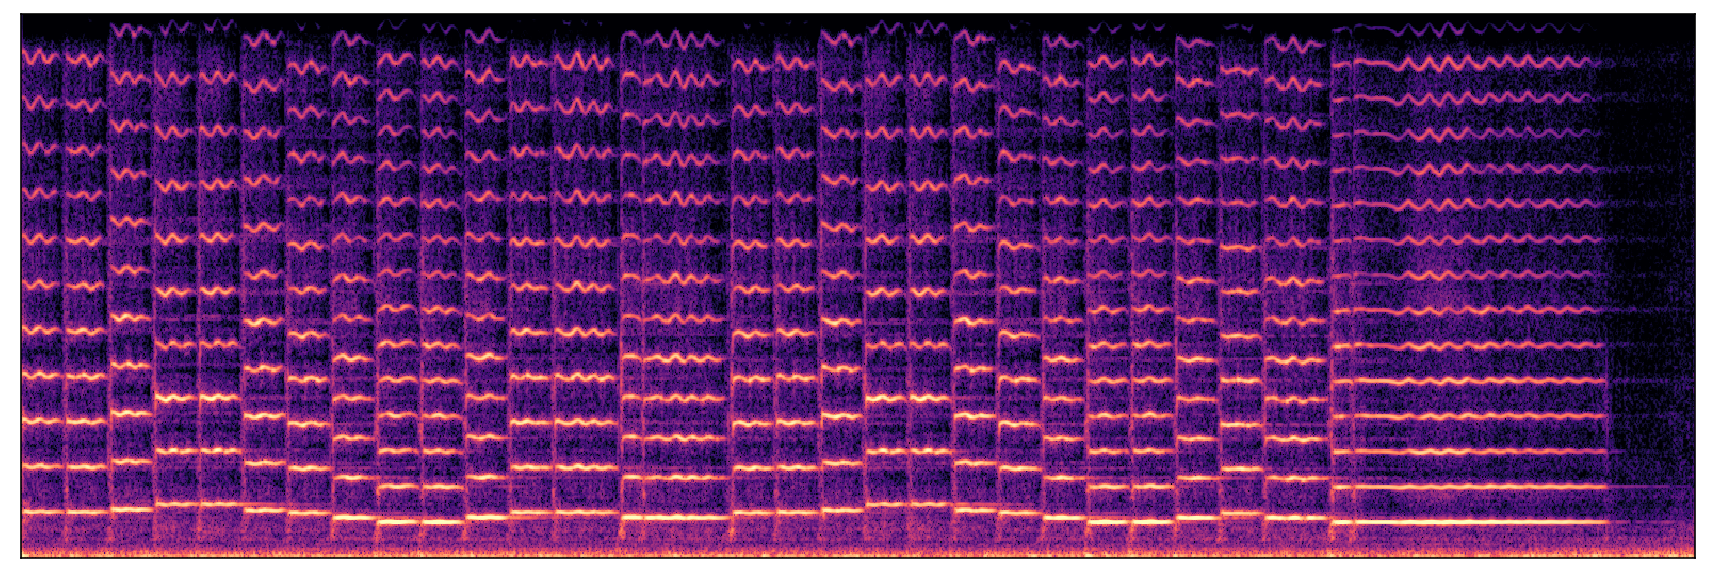

In [ ]:
#@markdown Let's first synthesize a MIDI using MIDI-DDSP! By running this cell without any change, MIDI-DDSP will synthesis the MIDI of "ode to joy" using violin. This will take about a minute.

#@markdown You can also upload your own MIDI file for MIDI-DDSP to synthesize! (by changing the `midi_file` to "Upload (.mid)")
#@markdown There are 13 instruments available. You can select instrument in the dropdown menu next to "instrument".
#@markdown Besides changing instruments and MIDI file, there are two variables you could change to adjust the MIDI synthesis:
#@markdown - `pitch_offset`: transpose the MIDI file for `pitch_offset` semitones. (>0 is pitch up, <0 is pitch down). 
#@markdown Different instrument has different pitch range. Please consider adjusting the `pitch_offset` for different instrument depending on the MIDI file.
#@markdown - `speed_rate`: adjust play speed of the MIDI (=1: original speed, >1: faster, <1: slower).

#@markdown In this cell, we will only synthesizing a single monophonic track. If you upload multi-track MIDI, only the first track will be used. You can synthesize multi-track MIDI using MIDI-DDSP in the cell below.

#@markdown The generation speed on a K80/CPU/TPU would be **5x** realtime, and on a P100 should be approximately **2.4x** realtime (we did not test on P100). That is, one need to wait 24-50 seconds for render a 10 second MIDI.

midi_file = 'Ode to Joy' #@param ['Ode to Joy','Upload (.mid)']

instrument = "violin"  #@param ['violin', 'viola', 'cello', 'double bass', 'flute', 'oboe', 'clarinet', 'saxophone', 'bassoon', 'trumpet', 'horn', 'trombone', 'tuba']

pitch_offset =  0#@param {type:"integer"}

speed_rate =  1#@param {type:"number", min:0}

if midi_file == 'Ode to Joy':
  midi_file = r'./midi-ddsp/midi_example/ode_to_joy.mid'
else:
  midi_file = upload_midi()[0]

instrument_name = instrument

instrument_id = INST_NAME_TO_ID_DICT[instrument_name]
midi_audio, midi_control_params, midi_synth_params, conditioning_df = synthesize_mono_midi(synthesis_generator, expression_generator, midi_file, instrument_id, output_dir=None, pitch_offset=pitch_offset, speed_rate=speed_rate)
plt.figure(figsize=(15,5))
plot_spec(midi_audio[0].numpy(), sr=16000)
plt.show()

## Adjusting Note Expression

In MIDI-DDSP, six note expression controls are designed and used to control the expressive performance, all in range of [0,1]. You can adjust them to edit the performance aspect of the MIDI synthesis:
 - Volume (`volume`): Controls overall volume of a note. (larger value -> larger volume)
 - Volume Fluctuation (`vol_fluc`): Controls the extent of the volume changing in a note (crescendo & decrescendo or not). (larger value -> more extensive dynamic changing)
 - Volume Peak Position (`vol_peak_pos`): Controls the volume changing in a note (crescendo & decrescendo, together with amplitude_std). (larger value -> later reach maximum volume)
 - Attack Noise (`attack_noise`): Controls the extent of note attack (strong or soft). (larger value -> larger attack)
 - Brightness (`brightness`): Controls the timbre of a note. (larger value -> brighter / more amplitude on higher harmonics)
 - Vibrato (`vibrato`): Controls the extend of the vibrato of a note. (larger value -> larger vibrato extend)

 

In [ ]:
#@markdown Run this cell to get an editable table for adjusting note expression.
#@markdown The values shown are predicted by note expression control generator.
#@markdown Each row is a note. Double click the item in the table and enter the value, click anywhere else to save the change. 

#@markdown After edit, the table is changed automatically and you can run the synthesize cell below the next cell to synthesize the result. 
#@markdown **Run this cell again will reset the table to the initial value.**

#@markdown You can also edit the note pitch and length just as editing a MIDI sequence.

qgrid_widget = qgrid.show_grid(conditioning_df_to_edit_df(conditioning_df), show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Generating: 100%|██████████| 4712/4712 [01:43<00:00, 45.61it/s]


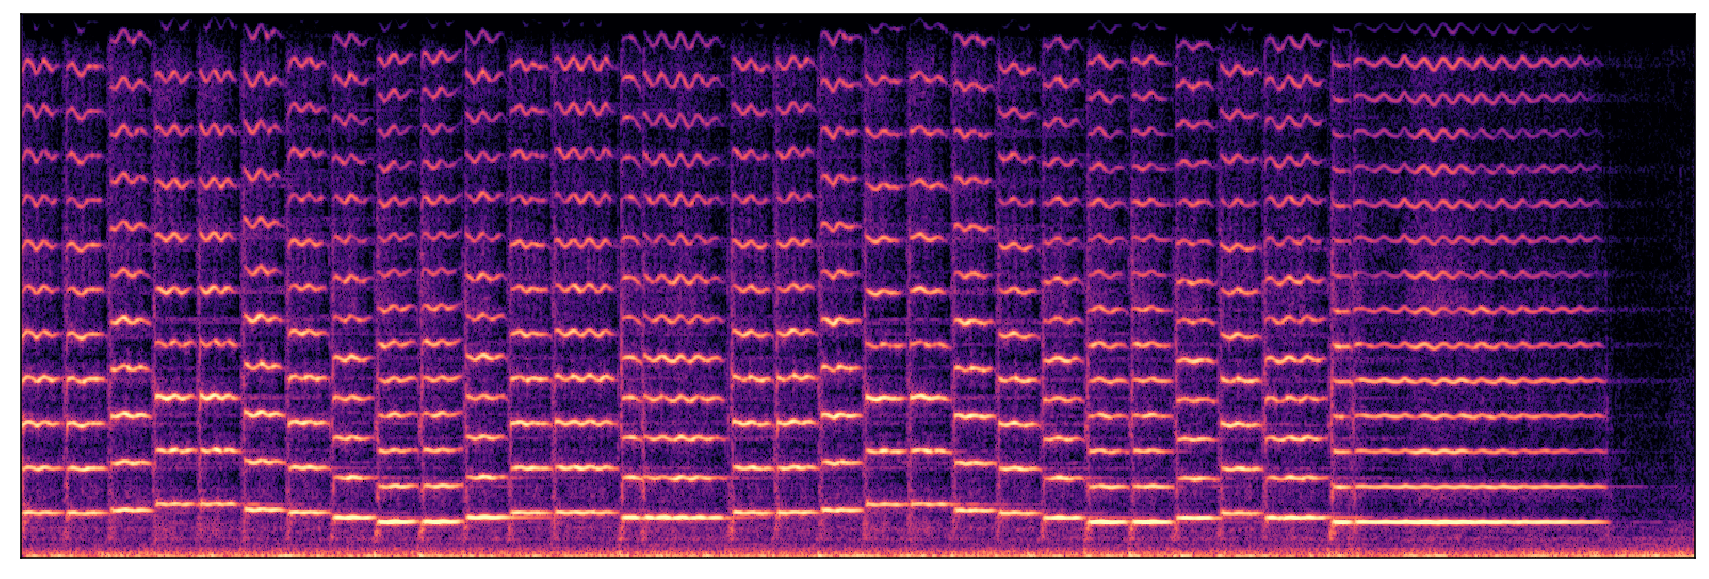

In [ ]:
#@markdown Run this cell to synthesize with edited note expression controls.

conditioning_df_changed = edit_df_to_conditioning_df(qgrid_widget.get_changed_df())
midi_audio, midi_control_params, midi_synth_params = conditioning_df_to_audio(synthesis_generator, conditioning_df_changed, tf.constant([instrument_id]), display_progressbar=True)
plt.figure(figsize=(15,5))
plot_spec(midi_audio[0].numpy(), sr=16000)
plt.show()

## Bach Chorales Synthesis

In [ ]:
#@markdown Besides synthesizing monophonic MIDI, MIDI-DDSP can also synthesizing multi-track MIDI.
#@markdown Running this cell to synthesis quartet of [4-part Bach Chorales](https://en.wikipedia.org/wiki/List_of_chorale_harmonisations_by_Johann_Sebastian_Bach).

#@markdown You can synthesize any Bach Chorales by typing in piece number to `piece_number` below. A full list of bach chorales available can be found [here](https://github.com/cuthbertLab/music21/tree/master/music21/corpus/bach).

#@markdown We provide three quartet settings, string, woodwind and brass wind. You can change the ensemble by selecting from the drop down menu of `ensemble`.


piece_number = 'bwv227.1' #@param {type:"string"}

ensemble = 'string_set' #@param ['string_set', 'woodwind_set', 'brasswind_set']

score = music21.corpus.parse(f'bach/{piece_number}')
score.write('midi', fp=f'./{piece_number}.mid')
midi_file = f'./{piece_number}.mid'
midi_audio_mix, midi_audio_all, midi_control_params, midi_synth_params, conditioning_df_all = synthesize_bach(
    synthesis_generator, 
    expression_generator, 
    midi_file, 
    quartet_set=ensemble, 
    pitch_offset=0, 
    speed_rate=1, 
    output_dir='./', 
    gain_adjust_db_dict=GAIN_ADJUST_DB_DICT[ensemble])

part_name = list(GAIN_ADJUST_DB_DICT[ensemble].keys())
plt.figure(figsize=(15,5))
plot_spec(midi_audio_mix, sr=16000, title='Mix')
plt.show()

for i in range(len(midi_audio_all)):
    plt.figure(figsize=(15,5))
    plot_spec(midi_audio_all[i], sr=16000, title=part_name[i])
    plt.show()

Generating:  71%|███████   | 6878/9750 [02:30<01:03, 45.55it/s]


KeyboardInterrupt: ignored

## Pitch Bend by Editing Synthesis Parameters

In [ ]:
#@markdown Run this cell to generate a pitch bend by editing synthesis parameters.
#@markdown You can double-click the cell to see how we do it in the code.
#@markdown This is just an example. 
#@markdown We encourage you to come up with smarter ways to smooth the connection and 
#@markdown crazy ways to play with the synthesis parameters :).

# First define functions to generate pitch bend. 
# You can come up with your own way of edit pitch or
# other synthesis parameters.

def get_pitch_bend(start_value, end_value, length, power=4,offset_1=-1,bend_type='exp'):
    if bend_type=='exp':
        if start_value <= end_value:
            value = start_value + (np.power(np.linspace(0.0, 1.0, num=length)+offset_1, power)-offset_1) * (end_value-start_value)
        return value
    elif bend_type=='linear':
        return np.linspace(start_value, end_value, length)

# First run the MIDI-DDSP to get the synthesis parameters predicted
# You don't need to run this if you already have the synthesis parameter prediction.
midi_file = r'./midi-ddsp/midi_example/ode_to_joy.mid'
instrument_name = 'violin'
instrument_id = INST_NAME_TO_ID_DICT[instrument_name]
midi_audio, midi_control_params, midi_synth_params, conditioning_df = synthesize_mono_midi(synthesis_generator, expression_generator, midi_file, instrument_id, output_dir=None, pitch_offset=pitch_offset, speed_rate=speed_rate)

# Assume we want to add a pitch bend in the middle of two notes. 
# The first note ends at frame 368 while the next note start at the frame 375

prev_note_off = 368
next_note_on = 375
f0_ori = midi_synth_params['f0_hz'][0,...,0]
amps_ori = midi_synth_params['amplitudes'].numpy()[0,...,0]
noise_ori = midi_synth_params['noise_magnitudes'].numpy()
hd_ori = midi_synth_params['harmonic_distribution'].numpy()

# Edit the f0 to add the pitch bend, starting from 
# 20 frames before the previous note off to 50 frames after next note on.
edit_frame_start = prev_note_off-20
edit_frame_end = next_note_on+50
edit_frame_duration = edit_frame_end - edit_frame_start

f0_changed = tf.concat([f0_ori[:edit_frame_start], 
            get_pitch_bend(f0_ori[edit_frame_start], 
                    f0_ori[edit_frame_end], 
                    (edit_frame_end)-(edit_frame_start), 
                    power=7, 
                    bend_type='exp'), 
            f0_ori[edit_frame_end:]], axis=0)
f0_changed = f0_changed[tf.newaxis, ..., tf.newaxis]

# For other synthesis parameters, use that from the start of the next note 
# to replace the connection of notes. 
# We also need to avoid the onset of the next note, 
# thus that is the reason we use "next_note_on+5" as the start.
amps_changed = amps_ori
amps_changed[edit_frame_start:edit_frame_end] = amps_ori[next_note_on+5:next_note_on+edit_frame_duration+5]
amps_changed = amps_changed[tf.newaxis, ..., tf.newaxis]
noise_changed = noise_ori
noise_changed[0,edit_frame_start:edit_frame_end,:] = noise_ori[0,next_note_on+5:next_note_on+edit_frame_duration+5,:]
hd_changed = hd_ori
hd_changed[0,edit_frame_start:edit_frame_end,:] = hd_changed[0,next_note_on+5:next_note_on+edit_frame_duration+5,:]

# Resynthesis the audio using DDSP
processor_group = get_process_group(midi_synth_params['amplitudes'].shape[1], use_angular_cumsum=True)
midi_audio_changed = processor_group({'amplitudes': amps_changed,
                        'harmonic_distribution': hd_changed,
                        'noise_magnitudes': noise_changed,
                        'f0_hz': f0_changed,},
                          verbose=False)
if synthesis_generator.reverb_module is not None:
    midi_audio_changed = synthesis_generator.reverb_module(midi_audio_changed, reverb_number=instrument_id, training=False)

plt.figure(figsize=(15,5))
# Just play the first 4 seconds
plot_spec(midi_audio[0].numpy()[:4*16000], sr=16000, title='Original')
plt.show()
plt.figure(figsize=(15,5))
plot_spec(midi_audio_changed[0].numpy()[:4*16000], sr=16000, title='Add pitch bend')
plt.show()

## Multi-track MIDI Synthesis

In [ ]:
#@markdown Run this cell to upload and synthesize any multi-track MIDI.

#@markdown For midi programs that are not supported by MIDI-DDSP, we will use [FluidSynth](https://www.fluidsynth.org/) to synthesize the track.
#@markdown For midi programs supported by MIDI-DDSP, it will only synthesize a monophonic performance. 
#@markdown That is, for a polyphonic track, only a polyphonic note sequence will be synthesized.

pitch_offset =  0#@param {type:"integer"}

speed_rate =  1#@param {type:"number", min:0}

midi_file = upload_midi()[0]

output = synthesize_midi(synthesis_generator, expression_generator, midi_file,
              pitch_offset=pitch_offset, speed_rate=speed_rate,
              output_dir=r'./',
              use_fluidsynth=True,
              sf2_path='./FluidR3_GM.sf2',
              display_progressbar=True)

plot_spec(output['midi_audio_mix'], sr=16000, title='Mix')

for i in range(len(output['stem_audio'])):
    plt.figure(figsize=(15,5))
    plot_spec(output['stem_audio'][i], sr=16000, title=f'Track {i}')
    plt.show()